In [3]:
import cv2
import numpy as np
import cPickle as pickle
from os.path import join

imgs_dir = '/home/zj1992/windows/work2/datasets/Flukes/CRC_combined constrained/'
patches_dir = '/home/zj1992/windows/work2/datasets/Flukes/patches/20150902_annot_nomissing'
def load_dataset(_dir):
    with open(join(_dir, 'train.pkl')) as f:
        train = pickle.load(f)
    with open(join(_dir, 'val.pkl')) as f:
        val = pickle.load(f)
    with open(join(_dir,'test.pkl')) as f:
        test = pickle.load(f)
    return (train, val, test)

(train_patches, train_labels), (val_patches, val_labels), (test_patches, test_labels) = load_dataset(patches_dir)

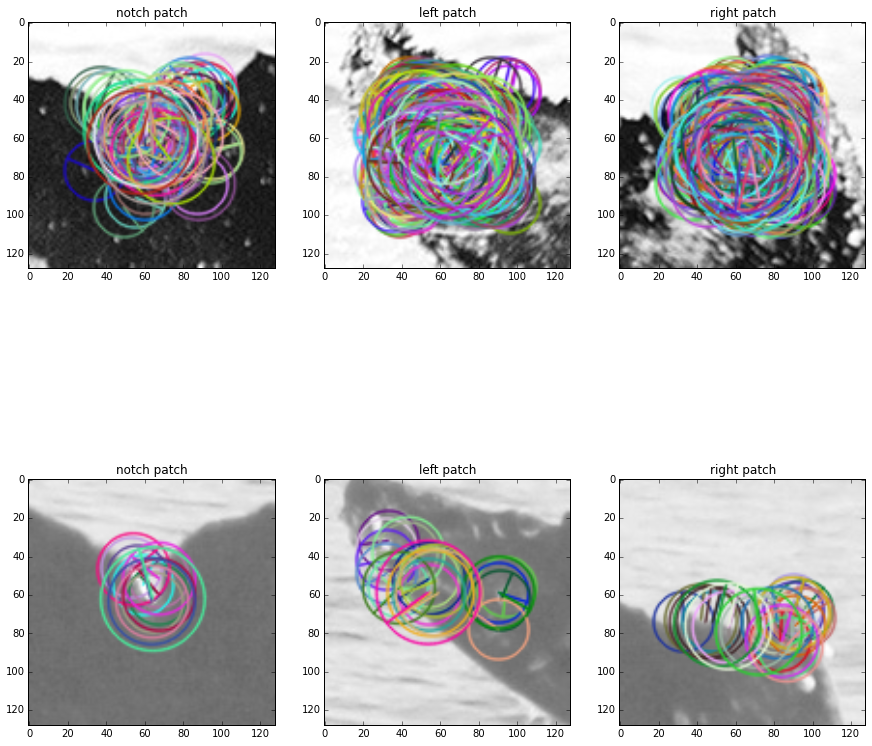

In [4]:
import copy
import matplotlib.pyplot as plt
%matplotlib inline

def view_combination(combo):
    f, axarr = plt.subplots(2,3,figsize=(15,15))
    for i in range(2):
        for label_ind, label in enumerate(['notch','left','right']):
            axarr[i][label_ind].set_title("%s patch" % label)
            axarr[i][label_ind].imshow(combo[i][label])
            
def orb_and_show(combo):
    orber = cv2.ORB()
    sift_drawn_combo = []
    for patchset in combo:
        drawn_on = {}
        for patch in patchset:
            kp = orber.detect(patchset[patch],None)
            drawable = cv2.cvtColor(copy.copy(patchset[patch]),cv2.COLOR_BGR2GRAY)
            drawn_on[patch] = cv2.drawKeypoints(drawable, kp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        sift_drawn_combo.append(drawn_on)
    view_combination(sift_drawn_combo)
#view_combination(random.choice(matching_combinations))
orb_and_show(train_patches[0])

In [5]:
# let's try brute force matching as outlined here: http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html
from itertools import product
from __future__ import division
import time
nokp = []
def best_ratio(desc1, desc2):
    # TODO make it not brute force if it gets reasonable results
    min_dist1 = np.inf
    min_dist2 = np.inf
    for i, j in product(range(desc1.shape[0]),
                        range(desc2.shape[0])):
        dist = np.linalg.norm(desc1[i] - desc2[j])
        if dist < min_dist1:
            min_dist1 = dist
        elif dist < min_dist2:
            min_dist2 = dist
    return min_dist1 / min_dist2

def get_best_match(combo):
    orber = cv2.SURF()
    ratios = []
    for patch in ['notch','left','right']:
        kps1 = orber.detect(combo[0][patch],None)
        kps2 = orber.detect(combo[1][patch],None)
        if len(kps2) == 0 or len(kps1) == 0:
            if len(kps2) == 0:
                nokp.append({'patch':patch,'img':combo[1][patch]})
            if len(kps1) == 0:
                nokp.append({'patch':patch,'img':combo[0][patch]})
            ratios.append(np.inf)
            continue
        kps1, desc1 = orber.compute(combo[0][patch], kps1)
        kps2, desc2 = orber.compute(combo[1][patch], kps2)
        
        
        ratios.append(best_ratio(desc1, desc2))
    # essentially what we've done is constrained the matching to be in specific regions
    # that we know should match. Ideally all three best ratios be below our threshold,
    # but if just one patch matches we'll accept it for now
    return ratios

train_ratios = [get_best_match(i) for i in train_patches]

/usr/lib/python2.7/site-packages/scikit_learn-0.15.2-py2.7-linux-x86_64.egg/sklearn/metrics/metrics.py:1771: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


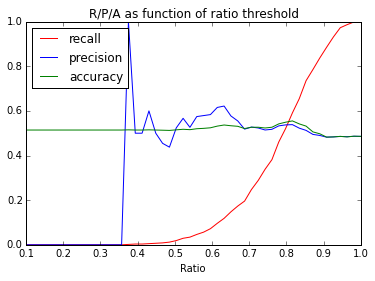

In [6]:
from sklearn.metrics import precision_score, recall_score, accuracy_score


rm_pred_train = []
times = []
def decision_func(ratios, target_ratio):
    return [int(any([r<target_ratio for r in ratio])) for ratio in ratios]

def plot_ratio_effect(ratio_range, ratios, true_labels):
    recalls = []
    precs = []
    accs = []
    for target_ratio in ratio_range: 
        predicted_labels = decision_func(ratios, target_ratio)
        recalls.append(recall_score(true_labels, predicted_labels))
        precs.append(precision_score(true_labels, predicted_labels))
        accs.append(accuracy_score(true_labels, predicted_labels))
    f, ax = plt.subplots(1)
    ax.plot(ratio_range, recalls, color='r', label='recall')
    ax.plot(ratio_range, precs, color='b', label='precision')
    ax.plot(ratio_range, accs, color='g', label='accuracy')
    ax.set_title('R/P/A as function of ratio threshold')
    ax.set_xlabel('Ratio')
    ax.legend(loc=2)

    
ratio_range = np.linspace(0.1,1)
plot_ratio_effect(ratio_range, train_ratios, train_labels)

In [10]:
def train_flat_models(patches, patch_labels, model):
    # take a model and train
    #estimator = model()
    patch_names = ['notch','left','right']
    # if separate, train a separate model for each patch label
    #if separate:
    datasets = {patch:([
                np.hstack([i[patch][j].reshape(-1) for j in range(2)]) for i in patches],patch_labels) for patch in patch_names}
    models = {}
    for patch in patch_names:
        patch_estimator = model()
        patch_estimator.fit(*datasets[patch])
        models[patch] = patch_estimator
    # note they don't learn to work together in any way
    return models

def majority(labelset):
    # assume it's just three labels of 1 or 0
    if labelset.count(0) > labelset.count(1):
        return 0
    else:
        return 1
def any_match(labelset):
    return int(any(labelset))
    
def all_match(labelset):
    return int(all(labelset))

def models_pred(patches, patch_labels, models, mode=any_match):
    # modes can be any, majority, and all
    patch_names = ['notch','left','right']
    datasets = {patch:([i[patch] for i in patches],patch_labels) for patch in patch_names}
    # get all of the predictions keyed by patch name
    predictions = {patch:models[patch].predict(datasets[patch][0]) for patch in patch_name}
    # get final predictions according to the mode
    final_pred = []
    for ind, _ in enumerate(patches):
        labelset = [predictions[patch][ind] for patch in patch_names]
        final_pred.append(mode(labelset))
    return final_pred

def evaluate_predictions(pred, true):
    print("Recall: %0.2f, Precision: %0.2f, Accuracy: %0.2f" % (recall_score(true, pred),
                                                                precision_score(true, pred),
                                                                accuracy_score(true, pred)))



In [11]:
from sklearn.linear_model import LogisticRegression
trained_models = train_flat_models(train_patches,train_labels,LogisticRegression)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:


# ORB features get 52% accuracy (if any match), SIFT gets ~54% accuracy. Awful
